# Model Final Training & Testing

This script is intended to load the clean *Amazon Reviews* training and testing datasets and, with the optimal set of hyperparameters previously found, obtain a definitive model with all training data and assess its quality with the testing data.

In [1]:
# Loading the necessary libraries
import numpy as np
import pandas as pd
import random
import torch
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
import pickle
import itertools
from sklearn.model_selection import train_test_split, KFold, cross_val_score
import shutil
import os
import json

In [2]:
# Init random seed to get reproducible results
seed = 1111
random.seed(seed)
np.random.RandomState(seed)
torch.manual_seed(seed)

## Data loading

In [3]:
# We preset data types in advance, to save memory
dtypes = {
        'class' : 'uint8',
        'review_text' : 'str'
}
train_dataset = pd.read_csv("../input/taed2-data-preparation/clean_amazon_reviews_train.csv", dtype=dtypes)
train_dataset

,class,review_text
0,2,I got this toy a couple of days ago and I ABSO...
1,2,Though lyrically the overall feel of this reco...
2,2,I have been looking for an anthology of outsta...
3,1,I tried/own both the pink and the orangish col...
4,2,Good coffee pot. Hot coffee. 6-8 cups makes a ...
...,...,...
179995,2,Wow what a helpful book. I was amazed at how a...
179996,2,This cd is pretty good.Why I give it 4.5 stars...
179997,2,I was so happy with everything! The delivery w...
179998,1,Dark shots of limp girls. Wouldn't really know...


In [4]:
# We preset data types in advance, to save memory
dtypes = {
        'class' : 'uint8',
        'review_text' : 'str'
}
test_dataset = pd.read_csv("../input/taed2-data-preparation/clean_amazon_reviews_test.csv", dtype=dtypes)
test_dataset

,class,review_text
0,1,"This is a good read for sure, but the problem ..."
1,2,I got this as a gift for my 10 year old nephew...
2,1,"According to the author, if you work hard, you..."
3,1,"Rambling and pointless, this overhyped tome se..."
4,2,Having read much about the exploits of Octavia...
...,...,...
19995,1,I have had this piece of @#*! for 3 years and ...
19996,1,This metronome is an excellent buy. The sound ...
19997,2,I love her books you get to know al the charac...
19998,1,"Trash,absolute trash. Can't you men stand the ..."


## Preliminary steps

In [5]:
class Dictionary(object):
    def __init__(self):
        self.token2idx = {}
        self.idx2token = []

    def add_token(self, token):
        if token not in self.token2idx:
            self.idx2token.append(token)
            self.token2idx[token] = len(self.idx2token) - 1
        return self.token2idx[token]

    def __len__(self):
        return len(self.idx2token)

In [6]:
char_vocab = Dictionary()
pad_token = '<pad>' # reserve index 0 for padding
unk_token = '<unk>' # reserve index 1 for unknown token
pad_index = char_vocab.add_token(pad_token)
unk_index = char_vocab.add_token(unk_token)

# join all the training and testing sentences in a single string
# and obtain the list of different characters with set
chars_train = set(''.join(train_dataset['review_text']))
chars_test = set(''.join(test_dataset['review_text']))
chars = chars_train.union(chars_test)

for char in sorted(chars):
    char_vocab.add_token(char)
print("Vocabulary:", len(char_vocab), "UTF characters")

class_vocab = Dictionary()
classes = set(train_dataset['class'])
for c in sorted(classes):
    class_vocab.add_token(c)
print("Labels:", len(class_vocab), "classes")

Vocabulary: 139 UTF characters
Labels: 2 classes


In [7]:
#From token or label to index
x_train_idx = [np.array([char_vocab.token2idx[c] for c in line]) for line in train_dataset['review_text']]
y_train_idx = np.array([class_vocab.token2idx[cl] for cl in train_dataset['class']])

x_test_idx = [np.array([char_vocab.token2idx[c] for c in line]) for line in test_dataset['review_text']]

In [8]:
train_data = [(x, y) for x, y in zip(x_train_idx, y_train_idx)]
test_data = [(x, idx) for idx, x in enumerate(x_test_idx)]

## Model definition

The necessary functions for applying a LSTM model are defined next.

In [9]:
def batch_generator(data, batch_size, token_size):
    """Yield elements from data in chunks with a maximum of batch_size sequences and token_size tokens."""
    minibatch, sequences_so_far, tokens_so_far = [], 0, 0
    for ex in data:
        seq_len = len(ex[0])
        if seq_len > token_size:
            ex = (ex[0][:token_size], ex[1])
            seq_len = token_size
        minibatch.append(ex)
        sequences_so_far += 1
        tokens_so_far += seq_len
        if sequences_so_far == batch_size or tokens_so_far == token_size:
            yield minibatch
            minibatch, sequences_so_far, tokens_so_far = [], 0, 0
        elif sequences_so_far > batch_size or tokens_so_far > token_size:
            yield minibatch[:-1]
            minibatch, sequences_so_far, tokens_so_far = minibatch[-1:], 1, len(minibatch[-1][0])
    if minibatch:
        yield minibatch

In [10]:
def pool_generator(data, batch_size, token_size, shuffle=False):
    """Sort within buckets, then batch, then shuffle batches.
    Partitions data into chunks of size 100*token_size, sorts examples within
    each chunk, then batch these examples and shuffle the batches.
    """
    for p in batch_generator(data, batch_size * 100, token_size * 100):
        p_batch = batch_generator(sorted(p, key=lambda t: len(t[0]), reverse=True), batch_size, token_size)
        p_list = list(p_batch)
        if shuffle:
            for b in random.sample(p_list, len(p_list)):
                yield b
        else:
            for b in p_list:
                yield b

In [11]:
class CharRNNClassifier(torch.nn.Module):
    
    def __init__(self, input_size, embedding_size, hidden_size, output_size, model="lstm", num_layers=2,
                 bidirectional=False, pad_idx=0):
        super().__init__()
        self.model = model.lower()
        self.hidden_size = hidden_size
        self.embed = torch.nn.Embedding(input_size, embedding_size, padding_idx=pad_idx)
        if self.model == "gru":
            self.rnn = torch.nn.GRU(embedding_size, hidden_size, num_layers, bidirectional=bidirectional)
        elif self.model == "lstm":
            self.rnn = torch.nn.LSTM(embedding_size, hidden_size, num_layers, bidirectional=bidirectional)
        self.h2o = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, input, input_lengths):
        encoded = self.embed(input)
        packed = torch.nn.utils.rnn.pack_padded_sequence(encoded, input_lengths)
        output, _ = self.rnn(packed)
        padded_mean, _ = torch.nn.utils.rnn.pad_packed_sequence(output, padding_value=0.0)
        padded_max, _ = torch.nn.utils.rnn.pad_packed_sequence(output, padding_value=float('-inf'))
        max_layer, _ = padded_max.max(dim=0)
        mean_layer = padded_mean.mean(dim=0)
        output = max_layer + mean_layer
        output = self.h2o(output)
        return output

In [12]:
if not torch.cuda.is_available():
    print("WARNING: CUDA is not available. Select 'GPU On' on kernel settings")
device = torch.device("cuda")
torch.cuda.manual_seed(seed)

In [13]:
criterion = torch.nn.CrossEntropyLoss(reduction='sum')

In [14]:
def train(model, optimizer, data, batch_size, token_size, max_norm, log=False):
    model.train()
    total_loss = ncorrect = nsentences = ntokens = niterations = 0
    
    for batch in pool_generator(data, batch_size, token_size, shuffle=True):
        X = [torch.from_numpy(d[0]) for d in batch]
        X_lengths = [x.numel() for x in X]
        ntokens += sum(X_lengths)
        X_lengths = torch.tensor(X_lengths, dtype=torch.long)
        y = torch.tensor([d[1] for d in batch], dtype=torch.long, device=device)
        X = torch.nn.utils.rnn.pad_sequence(X).to(device)
        model.zero_grad()
        output = model(X, X_lengths)
        loss = criterion(output, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()
        total_loss += loss.item()
        ncorrect += (torch.max(output, 1)[1] == y).sum().item()
        nsentences += y.numel()
        niterations += 1

    total_loss = total_loss / nsentences
    accuracy = 100 * ncorrect / nsentences
    if log:
        print(f'Train: wpb={ntokens//niterations}, bsz={nsentences//niterations}, num_updates={niterations}')
    return accuracy

In [15]:
def get_model():
    model = CharRNNClassifier(ntokens, embedding_size, hidden_size, nlabels, bidirectional=bidirectional, pad_idx=pad_index).to(device)
    optimizer = torch.optim.Adam(model.parameters())
    return model, optimizer

## Training the final model

In [16]:
# Definition of hyperparameter values (the optimal ones, according to the experiments)
hidden_size = 256
embedding_size = 32
bidirectional = False
batch_size = 32
token_size = 100000
epochs = 4
max_norm = 1

ntokens = len(char_vocab)
nlabels = len(class_vocab)

**Training loop**

Training the final model with all training data
Train: wpb=12970, bsz=32, num_updates=5625
| epoch 001 | train accuracy=80.5% (313s)
| epoch 002 | train accuracy=88.9% (627s)
| epoch 003 | train accuracy=91.0% (940s)
| epoch 004 | train accuracy=92.4% (1253s)


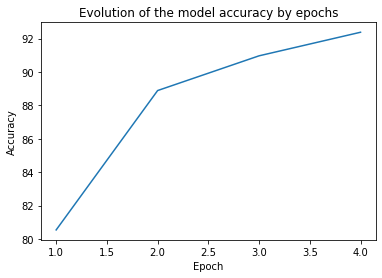

In [17]:
train_accuracy = []
model, optimizer = get_model()
print(f'Training the final model with all training data')
t0 = time.time()
for epoch in range(1, epochs + 1):
    acc = train(model, optimizer, train_data, batch_size, token_size, max_norm, log=epoch==1)
    train_accuracy.append(acc)
    print(f'| epoch {epoch:03d} | train accuracy={acc:.1f}% ({time.time() - t0:.0f}s)')

plt.plot(range(1, len(train_accuracy)+1), train_accuracy, label = "Final model")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Evolution of the model accuracy by epochs')
plt.show()

## Testing the final model

In [18]:
model

CharRNNClassifier(
  (embed): Embedding(139, 32, padding_idx=0)
  (rnn): LSTM(32, 256, num_layers=2)
  (h2o): Linear(in_features=256, out_features=2, bias=True)
)

In [19]:
def test(model, data, batch_size, token_size):
    model.eval()
    sindex = []
    labels = []
    with torch.no_grad():
        for batch in pool_generator(data, batch_size, token_size):
            # Get input sequences from batch
            X = [torch.from_numpy(d[0]) for d in batch]
            X_lengths = torch.tensor([x.numel() for x in X], dtype=torch.long)
            # Pad the input sequences to create a matrix
            X = torch.nn.utils.rnn.pad_sequence(X).to(device)
            answer = model(X, X_lengths)
            label = torch.max(answer, 1)[1].cpu().numpy()
            # Save labels and sentences index
            labels.append(label)
            sindex += [d[1] for d in batch]
            
    index = np.array(sindex)
    labels = np.concatenate(labels)
    order = np.argsort(index)
    labels = labels[order]
    labels = [l+1 for l in labels]
    testing_accuracy = sum(x == y for x, y in zip(test_dataset['class'], labels)) / len(labels)
    
    return labels, testing_accuracy

In [20]:
labels, testing_accuracy = test(model, test_data, batch_size, token_size)

In [21]:
print("Test accuracy:", testing_accuracy, '\n')
print("Printing some examples:", '\n')

for i in range(10):
    print("Input:", test_dataset['review_text'][i])
    print("Ground Truth:", test_dataset['class'][i])
    print("Prediction:", labels[i], '\n')

Test accuracy: 0.9069 

Printing some examples: 

Input: This is a good read for sure, but the problem I have with this book is Mr. Frey has no problem discounting a higher power/God, etc. and is willing to throw the Bible in the trash with used Q-Tips and used tissues, but he is eager and willing to take advice from Leonard - a cold-blooded, vengful killer, as well as adopt Leonard's catch phrase, "Just Hold On". Good advise for sure - I even saw a young man on the Oprah show tattoo this phrase on his arm. Good advise or not, the fact that this is where his inspiration is found says a lot about the author. I wish him well and I hope he continues his life of sobriety and continues to help others...whatever works I guess?
Ground Truth: 1
Prediction: 2 

Input: I got this as a gift for my 10 year old nephew who loves to go fishing. He needed some help getting the hooks out of the fish and this works great with his little hands. It fits nicely in his tackle box and the wood grain makes it

In [22]:
torch.save(model.state_dict(), "model.pt")

With the command above, the final trained model (in fact, its parameters set) has been saved.

Now, we can load it wherever and whenever we want to compute as many predictions as desired.

The end.